Шаг 1: Сбор данных о соседних точках доступа (AP) с помощью RSSI
Создадим Jupyter Notebook и напишем код для сбора данных о точках доступа с помощью библиотеки pywifi.

In [57]:
%pip install pywifi pandas matplotlib scikit-learn comtypes scapy

In [50]:
import pywifi
import time
import pandas as pd

# Функция для получения имени интерфейса Wi-Fi
def get_wifi_interface():
    wifi = pywifi.PyWiFi()
    interfaces = wifi.interfaces()
    if not interfaces:
        raise ValueError("No Wi-Fi interfaces found!")
    # Возвращаем имя первого интерфейса
    return interfaces[0]

# Получение интерфейса
iface = get_wifi_interface()
print(f"Using interface: {iface.name()}")

# Функция для сканирования сетей с помощью pywifi
def get_wifi_networks(iface):
    iface.scan()
    time.sleep(2)  # Ожидание завершения сканирования
    scan_results = iface.scan_results()
    
    networks = []
    for network in scan_results:
        ssid = network.ssid.encode('raw_unicode_escape').decode('utf-8', 'ignore')
        networks.append({
            'ssid': ssid,
            'bssid': network.bssid,
            'signal': network.signal
        })
    return networks

# Сканирование сетей
networks = get_wifi_networks(iface)
networks_df = pd.DataFrame(networks)
print(networks_df)

Using interface: Intel(R) Wi-Fi 6E AX211 160MHz
                ssid               bssid  signal
0      MTS_GPON_76A8  34:36:54:59:f1:d4:     -84
1       Роскомнадзор  30:de:4b:f8:48:d6:     -75
2      Keenetic-9861  58:8b:f3:6b:a6:64:     -84
3   *Not-connectable  a4:3b:0e:59:f9:74:     -45
4   *Not-connectable  a4:3b:0e:59:f9:70:     -34
5  OIS Airplane Crew  6c:5a:b0:9a:b1:ef:     -43
6            RA21017  1c:bd:b9:34:ab:5e:     -39


Шаг 2: Расчет расстояния на основе RSSI
Добавим функцию для расчета расстояния на основе RSSI и частоты сигнала.

In [51]:
def calculate_distance(rssi, frequency=2.4):
    RSSI_0 = -40  # Среднее значение RSSI на расстоянии 1 метр
    path_loss_exponent = 3.0  # Показатель затухания пути

    if rssi > 0:
        return -1

    distance = 10 ** ((RSSI_0 - rssi) / (10 * path_loss_exponent))
    return distance

# Пример использования
networks_df['distance'] = networks_df['signal'].apply(calculate_distance)
print(networks_df)

                ssid               bssid  signal   distance
0      MTS_GPON_76A8  34:36:54:59:f1:d4:     -84  29.286446
1       Роскомнадзор  30:de:4b:f8:48:d6:     -75  14.677993
2      Keenetic-9861  58:8b:f3:6b:a6:64:     -84  29.286446
3   *Not-connectable  a4:3b:0e:59:f9:74:     -45   1.467799
4   *Not-connectable  a4:3b:0e:59:f9:70:     -34   0.630957
5  OIS Airplane Crew  6c:5a:b0:9a:b1:ef:     -43   1.258925
6            RA21017  1c:bd:b9:34:ab:5e:     -39   0.926119


Шаг 3: Опрос пользователя координаты для полученных точек
Создадим функцию для опроса пользователя координат для полученных точек.

In [52]:
def collect_coordinates(networks):
    coordinates = []
    for network in networks:
        print(f"SSID: {network['ssid']}, BSSID: {network['bssid']}, Signal: {network['signal']}, Distance: {network['distance']:.2f} meters")
        distance = network['distance']
        angle = np.random.uniform(0, 2 * np.pi)
        x = distance * np.cos(angle)
        y = distance * np.sin(angle)
        coordinates.append((network['ssid'], x, y))
    return coordinates

coordinates = collect_coordinates(networks_df.to_dict('records'))
coordinates_df = pd.DataFrame(coordinates, columns=['ssid', 'x', 'y'])
print(coordinates_df)

SSID: MTS_GPON_76A8, BSSID: 34:36:54:59:f1:d4:, Signal: -84, Distance: 29.29 meters
SSID: Роскомнадзор, BSSID: 30:de:4b:f8:48:d6:, Signal: -75, Distance: 14.68 meters
SSID: Keenetic-9861, BSSID: 58:8b:f3:6b:a6:64:, Signal: -84, Distance: 29.29 meters
SSID: *Not-connectable, BSSID: a4:3b:0e:59:f9:74:, Signal: -45, Distance: 1.47 meters
SSID: *Not-connectable, BSSID: a4:3b:0e:59:f9:70:, Signal: -34, Distance: 0.63 meters
SSID: OIS Airplane Crew, BSSID: 6c:5a:b0:9a:b1:ef:, Signal: -43, Distance: 1.26 meters
SSID: RA21017, BSSID: 1c:bd:b9:34:ab:5e:, Signal: -39, Distance: 0.93 meters
                ssid          x          y
0      MTS_GPON_76A8  28.910098   4.679971
1       Роскомнадзор  14.563681   1.828299
2      Keenetic-9861   3.701591 -29.051577
3   *Not-connectable   1.458108   0.168395
4   *Not-connectable  -0.628672  -0.053657
5  OIS Airplane Crew  -0.869652  -0.910274
6            RA21017  -0.850151  -0.367341


Шаг 4: Построить схему 2D расположения координат
Используем matplotlib для визуализации расположения точек доступа.

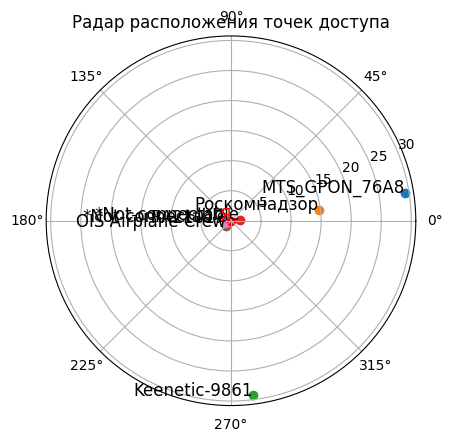

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_radar(coordinates):
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    for ssid, x, y in coordinates:
        r = np.sqrt(x**2 + y**2)
        theta = np.arctan2(y, x)
        ax.scatter(theta, r, label=ssid)
        ax.text(theta, r, ssid, fontsize=12, ha='right')
    
    # Добавляем вас в центр
    ax.scatter(0, 0, color='red')
    ax.text(0, 0, 'Я', fontsize=12, ha='right', color='red')
    
    ax.set_title('Радар расположения точек доступа')
    plt.show()

plot_radar(coordinates)